In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, report_fit
import pandas as pd
from scipy.constants import N_A

In [12]:
150e-6*N_A*1e-5/2e5

4516605570.0

In [13]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [14]:
def model_S_bispecific(t, z, Ainit, rtot1, rtot2, kon, kon1, k21, k22, koff1, koff2):
    k = Ainit*kon
    k1 = Ainit*kon1
    Atot = well_size*N_A*Ainit/Target_cell_number
    A0 = Atot - z[0] - z[1] - z[2]
    Ag1 = rtot1 - z[0] - z[2]
    Ag2 = rtot2 - z[1] - z[2]

    dA10 = (k*(Ag1)*(A0)/rtot1) - koff1*z[0] - (k22*(Ag2)*z[0]/rtot2) + koff2*z[2]
    dA01 = (k1*(Ag2)*(A0)/rtot2) - koff2*z[1] - (k21*(Ag1)*z[1]/rtot1) + koff1*z[2]
    dA11 = (k22*(Ag2)*z[0]/rtot2) + (k21*(Ag1)*z[1]/rtot1) - (koff1 + koff2)*z[2]

    return [dA10, dA01, dA11]

def solve_ode(x, params, i):

    rtot1 = params[f'rtot1_{i+1}']
    rtot2 = params[f'rtot2_{i+1}']
    kon1 = params[f'kon1_{i+1}']
    kon2 = params[f'kon2_{i+1}']
    k21 = params[f'k21_{i+1}']
    k22 = params[f'k22_{i+1}']
    koff1 = params[f'koff1_{i+1}']
    koff2 = params[f'koff2_{i+1}']

    ab_vals = np.zeros_like(x)
    ag1_vals = np.zeros_like(x)
    ag2_vals = np.zeros_like(x)
    
    for j, val in enumerate(x):
        A0 = 1e-9*val
        z = solve_ivp(model_S_bispecific, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot1, rtot2, kon1, kon2, 
                                                                                 k21, k22, koff1, koff2))
        
        A10 = z.y[0]
        A01 = z.y[1]
        A11 = z.y[2]
        A10_STST = A10[-1]
        A01_STST = A01[-1]
        A11_STST = A11[-1]

        Ag1 = (rtot1 - A10_STST - A11_STST)/rtot1
        Ag2 = (rtot2 - A01_STST - A11_STST)/rtot2
        Ab = 1 - (((rtot1 - A10_STST - A11_STST) + (rtot2 - A01_STST - A11_STST))/(rtot1 + rtot2))

        ab_vals[j] = Ab
        ag1_vals[j] = Ag1
        ag2_vals[j] = Ag2
    
    sols = [np.asarray(ag1_vals), np.asarray(ag2_vals), np.asarray(ab_vals)]

    return sols[i]
    
def objective(params, x, data):
    ndata =  data.shape[0]
    resid = 0.0*data[:]

    for i in range(ndata):
        resid[i][:] = data[i][:] - solve_ode(x, params, i)
    
    return resid.flatten()


In [15]:
df = pd.read_csv('pd1_10_1_data.csv')
x_data_pd1 = np.asarray(df['xdata'])    
y_data = np.asarray(df['ydata'])
y_data_pd1 = y_data/100

df1 = pd.read_csv('ctla4_data_10_1.csv')
x_data_ctla = np.asarray(df1['xdata'])
y_data1 = np.asarray(df1['ydata'])
y_data_ctla = y_data1/100

df2 = pd.read_csv('bispecific_pd1_ctla4_binding_data_10_1.csv')
x_data_ab = np.asarray(df2['xdata'])
y_data2 = np.asarray(df2['ydata'])
y_data_ab = y_data2/100

data = [y_data_pd1, y_data_ctla, y_data_ab]
data = np.array(data)
print(len(data[1]))

12


In [16]:
df = pd.read_csv('Mazor_bispecific_40_1.csv')
df1 = df[['Dataset_pd1_401', 'Unnamed: 1']]
x_data_pd1_40 = np.asarray(df1['Dataset_pd1_401'])
y_data_pd1_40 = np.asarray(df1['Unnamed: 1'])/100

df2 = df[['Dataset_ctla_40_1', 'Unnamed: 3']]
y_data_ctla4_40 = np.asarray(df2['Unnamed: 3'])/100

df3 = df[['Dataset_ab_binding_40_1', 'Unnamed: 5']]
y_data_ab_40 = np.asarray(df3['Unnamed: 5'])/100

data_40_1 = [y_data_pd1_40, y_data_ctla4_40, y_data_ab_40]
data_40_1 = np.array(data_40_1)

In [17]:
fit_params = Parameters()
for iy, y in enumerate(data_40_1):
    fit_params.add(f'rtot1_{iy+1}', value = 1e5, min=0, max = 1e7)
    fit_params.add(f'rtot2_{iy+1}', value = 1e5, min=0, max = 1e7)
    fit_params.add(f'kon1_{iy+1}', value = 1e5, min=0, max = 1e7)
    fit_params.add(f'kon2_{iy+1}', value = 1e5, min=0, max = 1e7)
    fit_params.add(f'k21_{iy+1}', value = 1e5, vary=False)#, min=0, max = 1e7)
    fit_params.add(f'k22_{iy+1}', value = 1e3, vary=False)#, min=0, max = 1e7)
    fit_params.add(f'koff1_{iy+1}', value = 1e-4,  min=0, max = 5e-1)
    fit_params.add(f'koff2_{iy+1}', value = 1e-4, min=0, max = 5e-1)

for iy in [2, 3]:
    fit_params[f'rtot1_{iy}'].expr = 'rtot1_1'
    fit_params[f'rtot2_{iy}'].expr = 'rtot2_1'
    fit_params[f'kon1_{iy}'].expr = 'kon1_1'
    fit_params[f'kon2_{iy}'].expr = 'kon2_1'
    fit_params[f'k21_{iy}'].expr = 'k21_1'
    fit_params[f'k22_{iy}'].expr = 'k22_1'
    fit_params[f'koff1_{iy}'].expr = 'koff1_1'
    fit_params[f'koff2_{iy}'].expr = 'koff2_1'

In [18]:
out = minimize(objective, fit_params, args=(x_data_pd1_40, data_40_1))

In [19]:
report_fit(out.params)

[[Variables]]
    rtot1_1:  118779.451 +/- 209628.326 (176.49%) (init = 100000)
    rtot2_1:  8834.68705 +/- 15530.9795 (175.80%) (init = 100000)
    kon1_1:   220751.751 +/- 502716.352 (227.73%) (init = 100000)
    kon2_1:   5760588.86 +/- 2643654.27 (45.89%) (init = 100000)
    k21_1:    100000 (fixed)
    k22_1:    1000 (fixed)
    koff1_1:  0.09558059 +/- 0.03731688 (39.04%) (init = 0.0001)
    koff2_1:  0.49725743 +/- 0.04329249 (8.71%) (init = 0.0001)
    rtot1_2:  118779.451 +/- 209628.326 (176.49%) == 'rtot1_1'
    rtot2_2:  8834.68705 +/- 15530.9796 (175.80%) == 'rtot2_1'
    kon1_2:   220751.751 +/- 502716.353 (227.73%) == 'kon1_1'
    kon2_2:   5760588.86 +/- 2643654.26 (45.89%) == 'kon2_1'
    k21_2:    100000.000 +/- 0.00000000 (0.00%) == 'k21_1'
    k22_2:    1000.00000 +/- 0.00000000 (0.00%) == 'k22_1'
    koff1_2:  0.09558059 +/- 0.03731688 (39.04%) == 'koff1_1'
    koff2_2:  0.49725743 +/- 0.04329249 (8.71%) == 'koff2_1'
    rtot1_3:  118779.451 +/- 209628.326 (176.49%

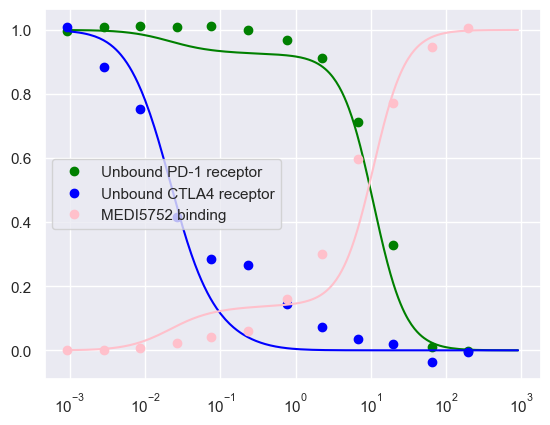

In [20]:
A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
A0s = []
vals = np.linspace(1, 9, 50)

import seaborn as sns
sns.set_theme()
for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s1 = np.asarray(A0s)/1e-9
colors = ['green', 'blue', 'pink']
labels = ['Unbound PD-1 receptor', 'Unbound CTLA4 receptor', 'MEDI5752 binding']
for i, solution in enumerate(data_40_1):
    y_fit = solve_ode(A0s1, out.params, i)

    plt.plot(x_data_pd1_40, data_40_1[i], 'o', color=colors[i], label=labels[i])
    plt.plot(A0s1, y_fit, color=colors[i])

plt.legend(loc='best')
plt.xscale('log')
plt.show()